### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math

import collections
from collections import defaultdict, deque

import pickle
import time
import os

# for building DQN model
#from keras import layers
#from keras import Sequential
#from keras.layers import Dense, Activation, Flatten
#from tensorflow.keras.optimizers import Adam

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

In [2]:
print(tf.config.list_physical_devices('GPU'))

[]


In [3]:
import tensorflow.compat.v1 as tf
from tensorflow import keras
from tensorflow.python.keras.callbacks import ModelCheckpoint

# Set the config values 
tf.disable_v2_behavior()
jobs = 8
config = tf.ConfigProto(intra_op_parallelism_threads=jobs,
                         inter_op_parallelism_threads=jobs,
                         allow_soft_placement=True,
                         device_count={'CPU': jobs})
# Create the session
session = tf.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

Instructions for updating:
non-resource variables are not supported in the long term



In [4]:
# Import the environment
from Env import CabDriver

([0], [(0, 0)])


#### Defining Time Matrix

In [5]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
Time_matrix[1,2,:,6]

array([7., 7., 7., 7., 7., 7., 4., 4., 4., 4., 4., 4., 2., 2., 2., 2., 2.,
       2., 8., 8., 8., 8., 8., 8.])

#### Some Tests to check environment bahviour

In [6]:
env = CabDriver()   
state = env.state_init
state

(3, 8, 5)

In [7]:
print(len(env.state_space))
print(len(env.action_space))

840
21


In [8]:
en_ac = env.action_encod_arch1((4,2))
en_ac

[0, 0, 0, 0, 1, 0, 0, 1, 0, 0]

In [9]:
env.state_space

[(0, 0, 0),
 (0, 0, 1),
 (0, 0, 2),
 (0, 0, 3),
 (0, 0, 4),
 (0, 0, 5),
 (0, 0, 6),
 (0, 1, 0),
 (0, 1, 1),
 (0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 2, 0),
 (0, 2, 1),
 (0, 2, 2),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 3, 0),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 3),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 4, 0),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 4),
 (0, 4, 5),
 (0, 4, 6),
 (0, 5, 0),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 5, 4),
 (0, 5, 5),
 (0, 5, 6),
 (0, 6, 0),
 (0, 6, 1),
 (0, 6, 2),
 (0, 6, 3),
 (0, 6, 4),
 (0, 6, 5),
 (0, 6, 6),
 (0, 7, 0),
 (0, 7, 1),
 (0, 7, 2),
 (0, 7, 3),
 (0, 7, 4),
 (0, 7, 5),
 (0, 7, 6),
 (0, 8, 0),
 (0, 8, 1),
 (0, 8, 2),
 (0, 8, 3),
 (0, 8, 4),
 (0, 8, 5),
 (0, 8, 6),
 (0, 9, 0),
 (0, 9, 1),
 (0, 9, 2),
 (0, 9, 3),
 (0, 9, 4),
 (0, 9, 5),
 (0, 9, 6),
 (0, 10, 0),
 (0, 10, 1),
 (0, 10, 2),
 (0, 10, 3),
 (0, 10, 4),
 (0, 10, 5),
 (0, 10, 6),
 (0, 11, 0),
 (0, 11, 1),
 (0, 11, 2),
 (0, 11, 3),
 (0, 11, 4),
 (0,

In [10]:
enc_st = env.state_encod_arch1(state)
len(enc_st)

36

In [11]:
pos_act_req, req = env.requests(state)
print(pos_act_req)
print(req)

[18, 19, 2, 8, 4, 9, 0]
[(4, 2), (4, 3), (0, 2), (1, 4), (0, 4), (2, 1), (0, 0)]


In [12]:
rf = env.reward_func(state, (1,2), Time_matrix)
rf

24.0

In [13]:
nstf = env.next_state_func(state, (1,2), Time_matrix)
nstf

([2, 8, 5], 15.0)

#### Tracking the state-action pairs for checking convergence


In [14]:
States_track = collections.defaultdict(dict)
print(len(States_track))

0


In [15]:
# Initialise states to be tracked
def initialise_tracking_states():
    sample_q_values = [((0, 0, 0), (0,1)), ((0, 0, 0), (0,2))]    
    for q_values in sample_q_values:
        state = q_values[0]
        action = q_values[1]
        States_track[state][action] = [] 

In [16]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [17]:
def initialize_tracking_states():
    state_action_pair = [((1, 0, 0), (1, 2)),
                         ((1, 1, 1), (4, 5)),
                         ((2, 2, 2), (1, 3)),
                         ((2, 2, 2), (3, 4)),
                         ((3, 3, 3), (3, 2)),
                         ((3, 3, 3), (4, 5)),
                         ((4, 4, 4), (4, 1)), 
                         ((4, 4, 4), (2, 1)),
                         ((5, 5, 5), (1, 2)),
                         ((5, 5, 5), (2, 3))]

    for st, ac in state_action_pair:
        if st not in tracked_states:
            tracked_states[st] = defaultdict()
        tracked_states[st][ac] = list()

In [18]:
def update_tracking_states(driver):
    for state in tracked_states.keys():
        encoded_state = envstate_encod_arch1(state)
        q_predict = agent.model.predict(encoded_state)

        for action in tracked_states[state].keys():
            action_index = list(
                filter(
                    lambda x: action == env.action_space[x],
                    range(0, len(env.action_space))))[0]
            q_value = q_predict[0][action_index]
            tracked_states[state][action].append(q_value)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

## Architecture Detail:
### - The input to the NN is only the state and its output is the Q-value of every possible action. 

In [19]:
# Hyperparameters

LR = 0.01
GAMMA = 0.9

batch_size = 32

Episodes = 10000 

max_epsilon = 1
min_epsilon = 0.0001
decay_rate = 0.0006        # epsilon decay rate

In [20]:
class DQNAgent:
    def __init__(self, state_size, action_size, discount_factor=GAMMA, learning_rate=LR,
                 epsilon=max_epsilon, epsilon_decay=decay_rate, epsilon_min=min_epsilon):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.epsilon_max = epsilon
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

        self.batch_size = 32
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        
        # Initialize the value of the states tracked
        self.states_tracked = []
        self.track_state = np.array(env.state_encod_arch1([0,0,0])).reshape(1, 36)

        # create main model and target model
        self.model = self.build_model()

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets   
        # hidden layers
        model.add(tf.keras.layers.Dense(32, input_dim=self.state_size, activation='relu',kernel_initializer='he_uniform'))
        model.add(tf.keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(tf.keras.layers.Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))

        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))
        model.summary
        return model

    def get_action(self, state, action_space, possible_actions_index):
        # Write your code here:
        # get action from model using epsilon-greedy policy
        # Decay in ε after we generate each sample from the environment
        if np.random.rand() <= self.epsilon:
            # explore: choose a random action from all possible actions
            # in case of cartpole this will randomly choose an action between 0 and 1
            index = random.randrange(len(possible_actions_index))
            action_index = possible_actions_index[index]
            action = action_space[action_index]
            return action_index, action

        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size

            state = np.array(state).reshape(1, self.state_size)
            q_value = self.model.predict(state)
            #print("action picked from compile model = {}".format(q_value))

            return np.argmax(q_value[0]), action_space[np.argmax(q_value[0])]

#    def get_action(self, state):
#    # Write your code here:        
#        poss_index, actions = env.requests(state)        
#    # get action from model using epsilon-greedy policy
#    # Decay in ε after we generate each sample from the environment       
#        if np.random.rand() <= self.epsilon_max:
#            # explore: choose a random action from all possible actions            
#            action = random.choice(actions)
#            return action
#        else:
#            # choose the action with the highest q(s, a)
#            # the first index corresponds to the batch size, so
#            # reshape state to (1, state_size) so that the first index corresponds to the batch size
#            state_encode = env.state_encod_arch1(state)
#            state_batch = state_encode.reshape(1, self.state_size)
#            q_value = self.model.predict(state_batch)
#            qvalue = [q_value[0][index] for index in poss_index]
#            #print("poss_index", poss_index, " actions ", actions, " state ",state)
#            if not poss_index:
#                return actions[0]
#            else:
#                index = np.argmax(qvalue)            
#                return actions[index] 

    def append_sample(self, state, action, reward, next_state, terminal):
        # Write your code here:
        # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, terminal))

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):

        if len(self.memory) > self.batch_size:
            
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)

            update_output = np.zeros((self.batch_size, self.state_size))  # write here
            update_input = np.zeros((self.batch_size, self.state_size))  # write here
            actions, rewards, done = [], [], []

            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)

            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                if done[i]:
                    target[i][actions[i]] = rewards[i]
                else:
                    target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
            
            # 4. Fit your model and track the loss values
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
    
    def store_q_values(self):
        """ We are keeping track of q value for state [0,0,0] and action (0,2)"""
        q_value = self.model.predict(self.track_state)
        self.states_tracked.append(q_value[0][2])
            
    def save(self, name):
        self.model.save(name)
        
    def save_model_weights(self, name):
        self.model.save_weights(name)
    

In [21]:
env = CabDriver()
agent = DQNAgent(action_size=len(env.action_space), state_size=len(env.state_encod_arch1(env.state_init)))

In [22]:
tracked_states = defaultdict()
initialize_tracking_states()

In [23]:
tracked_states

defaultdict(None,
            {(1, 0, 0): defaultdict(None, {(1, 2): []}),
             (1, 1, 1): defaultdict(None, {(4, 5): []}),
             (2, 2, 2): defaultdict(None, {(1, 3): [], (3, 4): []}),
             (3, 3, 3): defaultdict(None, {(3, 2): [], (4, 5): []}),
             (4, 4, 4): defaultdict(None, {(4, 1): [], (2, 1): []}),
             (5, 5, 5): defaultdict(None, {(1, 2): [], (2, 3): []})})

### DQN block

In [24]:
start_time = time.time()
rewards_per_episode, episodes, avg_rewards_per_episode = [], [], []

for episode in range(Episodes):

    # Write code here
    # Call the environment
    env = CabDriver()
    rewards = 0
    # Call all the initialised variables of the environment
    action_space, state_space, state = env.reset()

    terminal_state = False
    total_rideTime = 0
    count = 1
    while not terminal_state:
        #print("count = {}".format(count))
        count += 1
        # Write your code here
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        possible_actions_index, actions = env.requests(state)
        
        action_index, action = agent.get_action(env.state_encod_arch1(state), env.action_space, possible_actions_index)
        #action = agent.get_action(state)
        
        # 2. Evaluate your reward and next state
        next_state, rideTime = env.next_state_func(state, action,Time_matrix)
        
        # 3. Calculate reward
        reward = env.reward_func(state, action, Time_matrix)
        
        total_rideTime += rideTime
        #print(t)
        # TODO Do we need a logic to make sure that total time never goes more than 30 days. Which
        # TODO requires last ride to be less than the time left
        # TODO OR we not very hard strict with 30 days, driver can even work extra few hour just
        # TODO because of last ride
        if total_rideTime >= 24 * 30:
            terminal_state = True
        else:
            terminal_state = False
        
        # 4. Append the experience to the memory
        agent.append_sample(state, action_index, reward, next_state, terminal_state)
        # agent.append_sample(state, action, reward, next_state, terminal_state)
        
        # 5. Train the model by calling function agent.train_model
        agent.train_model()
        
        # 6. Keep a track of rewards, Q-values, loss
        state = next_state
        rewards += reward

    # store total reward obtained in this episode
    rewards_per_episode.append(rewards)
    episodes.append(episode)

    # epsilon decay
    if agent.epsilon > min_epsilon:
        agent.epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*episode)

    # every episode:
    if episode % 100 == 0:
        print("episode {0}, reward {1}, memory_length {2}, epsilon {3}, Total_rideTime {4}, terminated? {5}".format(episode,
                                                                                                   rewards,
                                                                                                   len(agent.memory),
                                                                                                   agent.epsilon,
                                                                                                   total_rideTime,
                                                                                                   terminal_state))
### TODO Keep a track of Q-values, loss
    # every few episodes:
    if episode % 100 == 0:
        # save model weights
        agent.save_model_weights(name="model_weights.h5")
        
    # every few episodes:
    if episode % 100 == 0:
        # store q-values of some prespecified state-action pairs
        agent.store_q_values()
        
    if episode % 500 == 0:
        elapsed_time = time.time() - start_time
        print('Total time taken ',elapsed_time)


# save stuff as pickle
def save_pickle(obj, name):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)
        
# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")

# save rewards_per_episode
save_pickle(rewards_per_episode, "saved_pickle_files/rewards_per_episode")

E:\Anaconda\envs\TfGpuEn\lib\site-packages\keras\engine\training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


episode 0, reward -152.0, memory_length 139, epsilon 1.0, Total_rideTime 727.0, terminated? True
Total time taken  0.7084240913391113
episode 100, reward -289.0, memory_length 2000, epsilon 0.9417703571308903, Total_rideTime 722.0, terminated? True
episode 200, reward -19.0, memory_length 2000, epsilon 0.8869317446734858, Total_rideTime 722.0, terminated? True
episode 300, reward -154.0, memory_length 2000, epsilon 0.8352866843901309, Total_rideTime 731.0, terminated? True
episode 400, reward 366.0, memory_length 2000, epsilon 0.7866491982804468, Total_rideTime 726.0, terminated? True
episode 500, reward 171.0, memory_length 2000, epsilon 0.7408441388596497, Total_rideTime 720.0, terminated? True
Total time taken  221.87235641479492
episode 600, reward 437.0, memory_length 2000, epsilon 0.6977065584384239, Total_rideTime 728.0, terminated? True
episode 700, reward 320.0, memory_length 2000, epsilon 0.6570811151330752, Total_rideTime 728.0, terminated? True
episode 800, reward 525.0, me

episode 6700, reward 2820.0, memory_length 2000, epsilon 0.018051169643008916, Total_rideTime 723.0, terminated? True
episode 6800, reward 2817.0, memory_length 2000, epsilon 0.017005774906140008, Total_rideTime 729.0, terminated? True
episode 6900, reward 2702.0, memory_length 2000, epsilon 0.016021259219361247, Total_rideTime 725.0, terminated? True
episode 7000, reward 2870.0, memory_length 2000, epsilon 0.015094077262795668, Total_rideTime 722.0, terminated? True
Total time taken  2872.5464878082275
episode 7100, reward 2880.0, memory_length 2000, epsilon 0.014220890179922945, Total_rideTime 720.0, terminated? True
episode 7200, reward -356.0, memory_length 2000, epsilon 0.013398553554089535, Total_rideTime 730.0, terminated? True
episode 7300, reward 1353.0, memory_length 2000, epsilon 0.012624106085212278, Total_rideTime 732.0, terminated? True
episode 7400, reward 2702.0, memory_length 2000, epsilon 0.011894758925899597, Total_rideTime 725.0, terminated? True
episode 7500, rewar

In [25]:
elapsed_time = time.time() - start_time
print('Total time taken ',elapsed_time)

Total time taken  4068.9197869300842


### Tracking Convergence

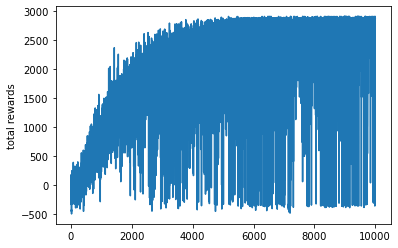

In [38]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

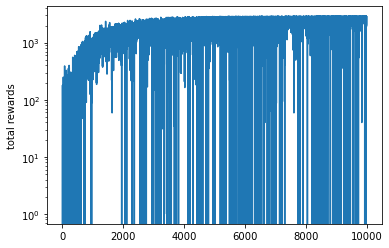

In [39]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.yscale("log")
plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.ylabel("total rewards")
plt.show()

In [27]:
# Average reward per 100 episode
avg_rewards = []
episodes = len(rewards_per_episode)
index = 0
track_total_reward = 0
for episode_number in range(episodes):
    if index != 50:
        track_total_reward += rewards_per_episode[episode_number]
        index += 1
    else:
        avg_rewards.append(track_total_reward/index)
        track_total_reward = rewards_per_episode[episode_number]
        index = 1

avg_rewards.append(track_total_reward/index)
        
    
print(avg_rewards)

[-138.26, -63.26, -59.06, -69.76, 25.84, -36.38, 57.52, 153.36, 122.34, 197.06, 285.32, 373.4, 484.66, 500.68, 454.22, 627.8, 668.82, 697.72, 699.84, 576.48, 855.94, 878.0, 936.44, 897.1, 1081.32, 1077.26, 1135.66, 1175.02, 1255.2, 1213.8, 1283.24, 1363.54, 1190.48, 1387.1, 1393.1, 1379.68, 1412.84, 1487.12, 1353.02, 1411.84, 1557.98, 1522.78, 1489.28, 1767.16, 1550.78, 1657.08, 1475.74, 1576.84, 1867.62, 1833.42, 1845.26, 1240.62, 1598.4, 1553.08, 1104.2, 1404.36, 1725.28, 1746.2, 1823.96, 1496.42, 1365.38, 1447.3, 1459.44, 1235.0, 1597.02, 1581.42, 1980.5, 2079.72, 1826.78, 2017.24, 1868.34, 1840.58, 2170.84, 1987.72, 2140.4, 2289.8, 2087.5, 2129.8, 2105.0, 2245.24, 2205.08, 2246.5, 2171.66, 2157.48, 2369.84, 2271.6, 2234.42, 2188.08, 2012.38, 2066.82, 2020.04, 2407.76, 2286.14, 2403.88, 2056.24, 1975.42, 2311.16, 2284.84, 2490.4, 2284.56, 2430.36, 2493.28, 2479.5, 2326.52, 2095.3, 2148.18, 2243.3, 2371.08, 2468.26, 2376.54, 2290.44, 1951.22, 2317.2, 2432.68, 2489.48, 2378.74, 2438.2

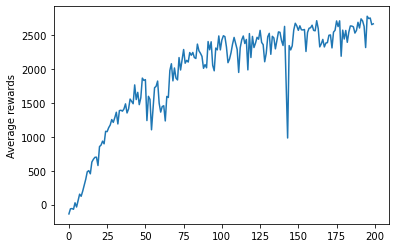

In [28]:
# Check Convergence by tracking total rewards per episode vs episode number
plt.plot(list(range(len(avg_rewards))), avg_rewards)
plt.ylabel("Average rewards")
plt.show()

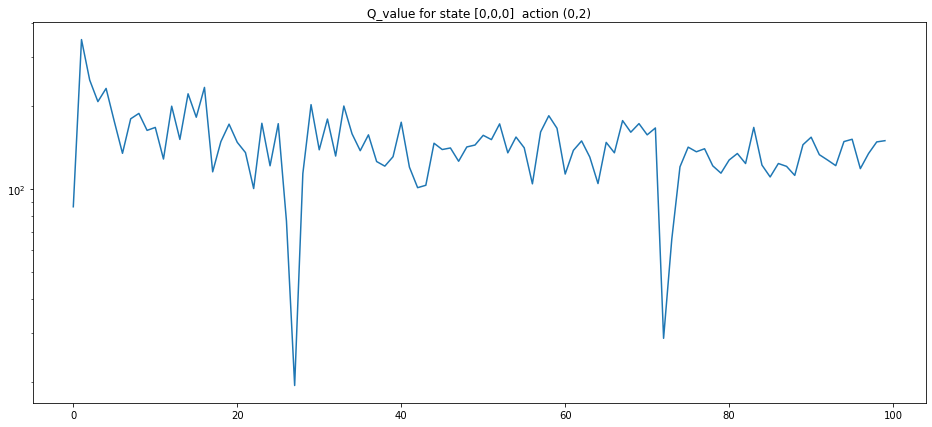

In [33]:
plt.figure(0, figsize=(16,7))
plt.title('Q_value for state [0,0,0]  action (0,2)')
xaxis = np.asarray(range(0, len(agent.states_tracked)))
plt.semilogy(xaxis,np.asarray(agent.states_tracked))
plt.show()

In [34]:
 for st in tracked_states.keys():
        for ac in tracked_states[st].keys():
            number_of_tracked_q_values = len(list(filter(lambda x: x!= 0, tracked_states[st][ac])))
            print('state - {0} - action - {1} - {2}'.format(st, ac, number_of_tracked_q_values))

state - (1, 0, 0) - action - (1, 2) - 0
state - (1, 1, 1) - action - (4, 5) - 0
state - (2, 2, 2) - action - (1, 3) - 0
state - (2, 2, 2) - action - (3, 4) - 0
state - (3, 3, 3) - action - (3, 2) - 0
state - (3, 3, 3) - action - (4, 5) - 0
state - (4, 4, 4) - action - (4, 1) - 0
state - (4, 4, 4) - action - (2, 1) - 0
state - (5, 5, 5) - action - (1, 2) - 0
state - (5, 5, 5) - action - (2, 3) - 0


In [35]:
tracked_states_plotting = [((1, 0, 0), (1, 2)),
                           ((3, 3, 3), (3, 2)),
                           ((4, 4, 4), (4, 1)), 
                           ((5, 5, 5), (2, 3))]

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [36]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0006*i))

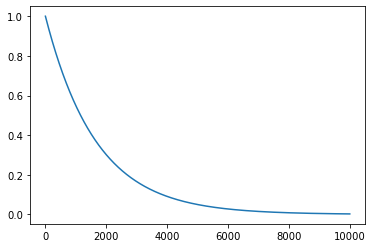

In [37]:
plt.plot(time, epsilon)
plt.show()